# Predicting return from Gold:
## Importing and Preparing Data:
For this and subsequent exercises we will need closing price of several instruments for past 10 years . There are various paid (Reuters, Bloomberg) and free resources (IEX, Quandl, Yahoofinance, Google finance) that we can use to either extract and load data in csv or we can directly call their APIs. Since in this project I needed different type of asset classes (Equities, Commodities, Debt and precious metals)

In [1]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install yahoofinancials
from yahoofinancials import YahooFinancials

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Import tickers 
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

<IPython.core.display.Javascript object>

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

Once we have the list, we need to define what date range we need to import the data for. The period I have chosen is Jan 2010 till 1st Mar 2020. The reason I did not pull data prior to that is because the GFC in 2008-09 massively changed the economic and market landscapes. Relationships pririo to that peirod might be of less relevance now. We also dont want to feed very less data as the models might tend to overfit.

We create a date-range and write it to an empty dataframe named values where we would extract and past the values we pull from yahoofinancials.

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-03-01"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once we have the date range in dataframe, we need to use ticker symbols to pull out data from the API. yahoofinancials returns the output in a JSON format. The following code loops over the the list of ticker symbols and extracts just the closing prices for all the historical dates and keeps them adding to the dataframe horizontally. Note I have used the merge function to mantain the sanctity of dates. Given these asset classes might have different regional and trading holidays, the date ranges are not bound to be the same. By merging, we will eventually have several NAs which we will frontfill later on.

In [5]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2651, 17)
Date                         0
Gold                       117
Silver                     117
Crude Oil                  116
S&P500                      95
Russel 2000 Index           95
10 Yr US T-Note futures    118
2 Yr US T-Note Futures     116
Platinum                   117
Copper                     117
Dollar Index               118
Volatility Index            95
Soybean                    116
MSCI EM ETF                 95
Euro USD                   311
Euronext100                 55
Nasdaq                      95
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.400024,18.868000,51.430000,3225.889893,1628.099976,132.656006,108.273003,971.700012,2.5925,99.283997,25.030001,874.25,41.429615,1.083905,1120.449951,9221.280273
2647,2020-02-25,1646.900024,18.183001,49.900002,3128.209961,1571.900024,133.125000,108.398003,929.799988,2.5965,98.901001,27.850000,879.00,41.101521,1.084920,1099.270020,8965.610352
2648,2020-02-26,1640.000000,17.826000,48.730000,3116.389893,1552.760010,133.328003,108.480003,912.299988,2.5765,98.938004,27.559999,881.00,41.429615,1.088200,1099.410034,8980.780273
2649,2020-02-27,1640.000000,17.658001,47.090000,2978.760010,1497.869995,133.438004,108.551003,903.599976,2.5715,98.460999,39.160000,895.00,40.435383,1.088589,1059.359985,8566.480469
2650,2020-02-28,1564.099976,16.386999,44.759998,2954.219971,1476.430054,134.843994,108.930000,862.799988,2.5460,98.081001,40.110001,891.75,40.286251,1.099723,1021.979980,8567.370117


In [7]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [8]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

<IPython.core.display.Javascript object>

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.4,18.9,51.4,3225.9,1628.1,132.7,108.3,971.7,2.6,99.3,25.0,874.2,41.4,1.1,1120.4,9221.3
2647,2020-02-25,1646.9,18.2,49.9,3128.2,1571.9,133.1,108.4,929.8,2.6,98.9,27.9,879.0,41.1,1.1,1099.3,8965.6
2648,2020-02-26,1640.0,17.8,48.7,3116.4,1552.8,133.3,108.5,912.3,2.6,98.9,27.6,881.0,41.4,1.1,1099.4,8980.8
2649,2020-02-27,1640.0,17.7,47.1,2978.8,1497.9,133.4,108.6,903.6,2.6,98.5,39.2,895.0,40.4,1.1,1059.4,8566.5
2650,2020-02-28,1564.1,16.4,44.8,2954.2,1476.4,134.8,108.9,862.8,2.5,98.1,40.1,891.8,40.3,1.1,1022.0,8567.4


In [9]:
values.to_csv("Training Data_Values.csv")

In [10]:
from pandas import DataFrame

imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2651, 1)


<IPython.core.display.Javascript object>

(2651, 17)


<IPython.core.display.Javascript object>

(2651, 33)


<IPython.core.display.Javascript object>

(2651, 49)


<IPython.core.display.Javascript object>

(2651, 65)


<IPython.core.display.Javascript object>

(2651, 81)
(2651, 81)


<IPython.core.display.Javascript object>

(2651, 86)


<IPython.core.display.Javascript object>

(2651, 91)


<IPython.core.display.Javascript object>

(2651, 96)


<IPython.core.display.Javascript object>

(2651, 101)


Besides just the lagged returns, we also see how far the current Gold price is from its moving average for with different window. This is a very commonly used metric in technical analysis where moving averages offer supports and resistances for asset prices. We use a combination of simple and exponential moving averages. We then add these moving averages to the existing feature space.

In [11]:
#Calculating Moving averages for Gold
ma = DataFrame(values['Date'],columns=['Date'])
ma['Date']=pd.to_datetime(ma['Date'],format='%Y-%b-%d')
ma['15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
ma['30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
ma['60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
ma['90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
ma['180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
ma['90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
ma['180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
ma = ma.dropna(axis=0)
print(ma.shape)
ma.head()

<IPython.core.display.Javascript object>

(2472, 8)


,Date,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


In [12]:
#Merging Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=ma,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2651, 101)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2651, 108)


Date                              0
Gold-T-1                          1
Silver-T-1                        1
Crude Oil-T-1                     1
S&P500-T-1                        1
Russel 2000 Index-T-1             1
10 Yr US T-Note futures-T-1       1
2 Yr US T-Note Futures-T-1        1
Platinum-T-1                      1
Copper-T-1                        1
Dollar Index-T-1                  1
Volatility Index-T-1              1
Soybean-T-1                       1
MSCI EM ETF-T-1                   1
Euro USD-T-1                      1
Euronext100-T-1                   1
Nasdaq-T-1                        1
Gold-T-3                          3
Silver-T-3                        3
Crude Oil-T-3                     3
S&P500-T-3                        3
Russel 2000 Index-T-3             3
10 Yr US T-Note futures-T-3       3
2 Yr US T-Note Futures-T-3        3
Platinum-T-3                      3
Copper-T-3                        3
Dollar Index-T-3                  3
Volatility Index-T-3        

This wall all about features. Now we need to create targets, i.e what we want to predict. Since we are predicting returns, we need to pick a horizon for which we need to predict returns. I have chosen 14-day and 22-day horizons because other smaller horizons tend to be very volatile and lack and predictive power. One can however, experiment with other horizons as well.



In [13]:
#Caluculating forward returns for Target
y = DataFrame(data=values['Date'])
print(y.shape)

y['T+14']=values["Gold"].pct_change(periods=-14)
y['T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2651, 1)
(2651, 3)


Date     0
T+14    14
T+22    22
dtype: int64

In [16]:
# Removing NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['T+22'].notna()]
print(data.shape)
print(y.shape)

(2401, 108)
(2401, 108)
(2629, 3)


In [17]:
# Now we will merge the Target variables with the feature space to get a data whcih we can finally start modelling on.

from pandas import merge

#Adding Target Variables
data = merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2379, 110)


Date                            0
Gold-T-1                        0
Silver-T-1                      0
Crude Oil-T-1                   0
S&P500-T-1                      0
Russel 2000 Index-T-1           0
10 Yr US T-Note futures-T-1     0
2 Yr US T-Note Futures-T-1      0
Platinum-T-1                    0
Copper-T-1                      0
Dollar Index-T-1                0
Volatility Index-T-1            0
Soybean-T-1                     0
MSCI EM ETF-T-1                 0
Euro USD-T-1                    0
Euronext100-T-1                 0
Nasdaq-T-1                      0
Gold-T-3                        0
Silver-T-3                      0
Crude Oil-T-3                   0
S&P500-T-3                      0
Russel 2000 Index-T-3           0
10 Yr US T-Note futures-T-3     0
2 Yr US T-Note Futures-T-3      0
Platinum-T-3                    0
Copper-T-3                      0
Dollar Index-T-3                0
Volatility Index-T-3            0
Soybean-T-3                     0
MSCI EM ETF-T-

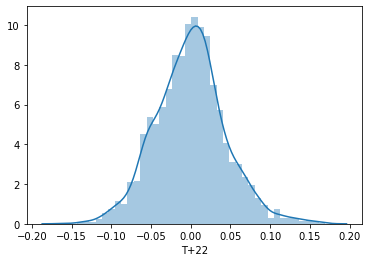

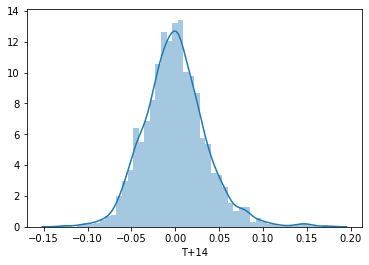

In [19]:
import seaborn as sns
sns.distplot(data['T+22']); plt.show()
sns.distplot(data['T+14']); plt.show()

In [20]:
data.to_csv("Training Data.csv",index=False)

## Creating Labels
We will try to predict any adverse (negative) return in Gold beyond a threshold.This threshold can be defined based on the risk tolerance of the investor. Here, I have taken the threshold to be 15% lowest return observations in the data history. In effect I am training to the model to predict a fall equal to or worse than 394 worse days in past 10 years.

In [21]:
import scipy.stats as st
#Select Threshold p (left tail probability)
p= 0.15
#Get z-Value
z = st.norm.ppf(p)
print(z)

-1.0364333894937898


In [22]:
#Calculating Threshold (t) for each Y
t_14 = round((z*np.std(data["T+14"]))+np.mean(data["T+14"]),5)
t_22 = round((z*np.std(data["T+22"]))+np.mean(data["T+22"]),5)

print("t_14=",t_14)
print("t_22=",t_22)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

t_14= -0.03733
t_22= -0.04633


So We can see above that threshold for 14-day model is -0.037 or -3.7%. This means that Gold returns over 140day period has been lower than -3.7% only 15 out of 100 days. We will label them as Target outcomes. Similar for T+22 days and T+5 Days

In [23]:
#Creating Labels
data['Y-14'] = (data['T+14']< t_14)*1
data['Y-22']= (data['T+22']< t_22)*1
print("Y-14", sum(data['Y-14']))
print("Y-22", sum(data['Y-22']))

Y-14 338
Y-22 356


In [24]:
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,Dollar Index-T-1,Volatility Index-T-1,Soybean-T-1,MSCI EM ETF-T-1,Euro USD-T-1,Euronext100-T-1,Nasdaq-T-1,Gold-T-3,Silver-T-3,Crude Oil-T-3,S&P500-T-3,Russel 2000 Index-T-3,10 Yr US T-Note futures-T-3,2 Yr US T-Note Futures-T-3,Platinum-T-3,Copper-T-3,Dollar Index-T-3,Volatility Index-T-3,Soybean-T-3,MSCI EM ETF-T-3,Euro USD-T-3,Euronext100-T-3,Nasdaq-T-3,Gold-T-5,Silver-T-5,Crude Oil-T-5,S&P500-T-5,Russel 2000 Index-T-5,10 Yr US T-Note futures-T-5,2 Yr US T-Note Futures-T-5,Platinum-T-5,Copper-T-5,Dollar Index-T-5,Volatility Index-T-5,Soybean-T-5,MSCI EM ETF-T-5,Euro USD-T-5,Euronext100-T-5,Nasdaq-T-5,Gold-T-14,Silver-T-14,Crude Oil-T-14,S&P500-T-14,Russel 2000 Index-T-14,10 Yr US T-Note futures-T-14,2 Yr US T-Note Futures-T-14,Platinum-T-14,Copper-T-14,Dollar Index-T-14,Volatility Index-T-14,Soybean-T-14,MSCI EM ETF-T-14,Euro USD-T-14,Euronext100-T-14,Nasdaq-T-14,Gold-T-21,Silver-T-21,Crude Oil-T-21,S&P500-T-21,Russel 2000 Index-T-21,10 Yr US T-Note futures-T-21,2 Yr US T-Note Futures-T-21,Platinum-T-21,Copper-T-21,Dollar Index-T-21,Volatility Index-T-21,Soybean-T-21,MSCI EM ETF-T-21,Euro USD-T-21,Euronext100-T-21,Nasdaq-T-21,Gold-T-60,Silver-T-60,Crude Oil-T-60,S&P500-T-60,MSCI EM ETF-T-60,Gold-T-90,Silver-T-90,Crude Oil-T-90,S&P500-T-90,MSCI EM ETF-T-90,Gold-T-180,Silver-T-180,Crude Oil-T-180,S&P500-T-180,MSCI EM ETF-T-180,Gold-T-250,Silver-T-250,Crude Oil-T-250,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,T+14,T+22,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,0.003727,-0.074713,0.007603,0.002660,0.0,-0.003706,0.002161,-0.017811,-0.023490,-0.003398,0.001852,0.010108,0.008306,0.000913,-0.007538,0.00000,0.013802,-0.085227,0.002160,-0.010499,0.0,-0.007244,0.005823,-0.004118,0.017483,0.002278,0.002822,0.003476,0.000824,0.000913,0.016883,0.02439,0.008739,-0.085227,0.020267,-0.002646,0.0,-0.000286,0.002085,0.009224,0.073801,0.026838,0.047230,0.064891,-0.028022,-0.000912,0.042920,0.105263,-0.001236,-0.251163,0.051660,0.027248,0.0,0.054943,0.046650,0.018996,0.085821,0.075795,0.039442,0.081437,-0.024900,-0.000912,0.020795,0.105263,0.026684,-0.143617,0.045733,-0.002646,-0.071429,-0.000429,0.051145,0.063735,0.359813,0.150327,0.082876,0.053073,0.134744,0.607735,0.167109,0.152613,0.142424,0.187322,0.590164,0.036514,0.041443,0.067989,0.233426,0.672414,0.079755,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250,0.007675,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,0.002475,0.018634,0.012627,-0.005305,0.0,0.004006,0.002497,0.000000,0.003425,0.002257,0.009634,0.018090,0.010833,0.000913,0.005171,0.02439,0.004963,-0.083799,0.014423,0.000000,0.0,0.002715,0.012380,-0.008445,-0.010135,0.002257,0.005320,0.013211,-0.003287,0.000913,0.009382,0.00000,0.017588,-0.062857,0.009750,-0.015748,0.0,-0.001991,0.009410,0.000361,0.039007,0.055886,0.056327,0.076066,-0.029600,-0.001821,0.036537,0.105263,-0.003690,-0.302128,0.058085,0.030220,0.0,0.066413,0.060604,0.024627,0.077206,0.089571,0.039510,0.079928,-0.025703,0.000000,0.023697,0.105263,0.030534,-0.088889,0.094632,-0.007937,-0.071429,0.005589,0.052222,0.068482,0.362791,0.160784,0.091840,0.047486,0.131482,0.592391,0.180851,0.155364,0.126126,0.192751,0.592391,0.053381,0.042290,0.071429,0.239599,0.683908,0.089571,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422,0.011166,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,0.001235,0.006098,0.008364,0.016000,0.0,0.010118,0.006793,0.012989,0.020833,0.023945,0.009413,0.017899,0.006645,0.000000,0.015211,0.04878,0.007453,-0.051724,0.028860,0.013298,0.0,0.010406,0.011489,-0.010972,-0.013423,0.016988,0.010470,0.024362,0.006645,0.000000,0.006135,0.023

In [25]:
# Now that we have the labels to predict, we can delet the return columns

data = data.drop(['T+14','T+22'],axis=1)
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,Dollar Index-T-1,Volatility Index-T-1,Soybean-T-1,MSCI EM ETF-T-1,Euro USD-T-1,Euronext100-T-1,Nasdaq-T-1,Gold-T-3,Silver-T-3,Crude Oil-T-3,S&P500-T-3,Russel 2000 Index-T-3,10 Yr US T-Note futures-T-3,2 Yr US T-Note Futures-T-3,Platinum-T-3,Copper-T-3,Dollar Index-T-3,Volatility Index-T-3,Soybean-T-3,MSCI EM ETF-T-3,Euro USD-T-3,Euronext100-T-3,Nasdaq-T-3,Gold-T-5,Silver-T-5,Crude Oil-T-5,S&P500-T-5,Russel 2000 Index-T-5,10 Yr US T-Note futures-T-5,2 Yr US T-Note Futures-T-5,Platinum-T-5,Copper-T-5,Dollar Index-T-5,Volatility Index-T-5,Soybean-T-5,MSCI EM ETF-T-5,Euro USD-T-5,Euronext100-T-5,Nasdaq-T-5,Gold-T-14,Silver-T-14,Crude Oil-T-14,S&P500-T-14,Russel 2000 Index-T-14,10 Yr US T-Note futures-T-14,2 Yr US T-Note Futures-T-14,Platinum-T-14,Copper-T-14,Dollar Index-T-14,Volatility Index-T-14,Soybean-T-14,MSCI EM ETF-T-14,Euro USD-T-14,Euronext100-T-14,Nasdaq-T-14,Gold-T-21,Silver-T-21,Crude Oil-T-21,S&P500-T-21,Russel 2000 Index-T-21,10 Yr US T-Note futures-T-21,2 Yr US T-Note Futures-T-21,Platinum-T-21,Copper-T-21,Dollar Index-T-21,Volatility Index-T-21,Soybean-T-21,MSCI EM ETF-T-21,Euro USD-T-21,Euronext100-T-21,Nasdaq-T-21,Gold-T-60,Silver-T-60,Crude Oil-T-60,S&P500-T-60,MSCI EM ETF-T-60,Gold-T-90,Silver-T-90,Crude Oil-T-90,S&P500-T-90,MSCI EM ETF-T-90,Gold-T-180,Silver-T-180,Crude Oil-T-180,S&P500-T-180,MSCI EM ETF-T-180,Gold-T-250,Silver-T-250,Crude Oil-T-250,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,0.003727,-0.074713,0.007603,0.002660,0.0,-0.003706,0.002161,-0.017811,-0.023490,-0.003398,0.001852,0.010108,0.008306,0.000913,-0.007538,0.00000,0.013802,-0.085227,0.002160,-0.010499,0.0,-0.007244,0.005823,-0.004118,0.017483,0.002278,0.002822,0.003476,0.000824,0.000913,0.016883,0.02439,0.008739,-0.085227,0.020267,-0.002646,0.0,-0.000286,0.002085,0.009224,0.073801,0.026838,0.047230,0.064891,-0.028022,-0.000912,0.042920,0.105263,-0.001236,-0.251163,0.051660,0.027248,0.0,0.054943,0.046650,0.018996,0.085821,0.075795,0.039442,0.081437,-0.024900,-0.000912,0.020795,0.105263,0.026684,-0.143617,0.045733,-0.002646,-0.071429,-0.000429,0.051145,0.063735,0.359813,0.150327,0.082876,0.053073,0.134744,0.607735,0.167109,0.152613,0.142424,0.187322,0.590164,0.036514,0.041443,0.067989,0.233426,0.672414,0.079755,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,0.002475,0.018634,0.012627,-0.005305,0.0,0.004006,0.002497,0.000000,0.003425,0.002257,0.009634,0.018090,0.010833,0.000913,0.005171,0.02439,0.004963,-0.083799,0.014423,0.000000,0.0,0.002715,0.012380,-0.008445,-0.010135,0.002257,0.005320,0.013211,-0.003287,0.000913,0.009382,0.00000,0.017588,-0.062857,0.009750,-0.015748,0.0,-0.001991,0.009410,0.000361,0.039007,0.055886,0.056327,0.076066,-0.029600,-0.001821,0.036537,0.105263,-0.003690,-0.302128,0.058085,0.030220,0.0,0.066413,0.060604,0.024627,0.077206,0.089571,0.039510,0.079928,-0.025703,0.000000,0.023697,0.105263,0.030534,-0.088889,0.094632,-0.007937,-0.071429,0.005589,0.052222,0.068482,0.362791,0.160784,0.091840,0.047486,0.131482,0.592391,0.180851,0.155364,0.126126,0.192751,0.592391,0.053381,0.042290,0.071429,0.239599,0.683908,0.089571,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,0.001235,0.006098,0.008364,0.016000,0.0,0.010118,0.006793,0.012989,0.020833,0.023945,0.009413,0.017899,0.006645,0.000000,0.015211,0.04878,0.007453,-0.051724,0.028860,0.013298,0.0,0.010406,0.011489,-0.010972,-0.013423,0.016988,0.010470,0.024362,0.006645,0.000000,0.006135,0.02381,0.017566,-0.062500,0.023302,0.000000,0.0,0.

# 22-Day Model

In [26]:
!pip install pycaret
from pycaret.classification import *

In [27]:
data_22 = data.drop(['Y-14'],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,Dollar Index-T-1,Volatility Index-T-1,Soybean-T-1,MSCI EM ETF-T-1,Euro USD-T-1,Euronext100-T-1,Nasdaq-T-1,Gold-T-3,Silver-T-3,Crude Oil-T-3,S&P500-T-3,Russel 2000 Index-T-3,10 Yr US T-Note futures-T-3,2 Yr US T-Note Futures-T-3,Platinum-T-3,Copper-T-3,Dollar Index-T-3,Volatility Index-T-3,Soybean-T-3,MSCI EM ETF-T-3,Euro USD-T-3,Euronext100-T-3,Nasdaq-T-3,Gold-T-5,Silver-T-5,Crude Oil-T-5,S&P500-T-5,Russel 2000 Index-T-5,10 Yr US T-Note futures-T-5,2 Yr US T-Note Futures-T-5,Platinum-T-5,Copper-T-5,Dollar Index-T-5,Volatility Index-T-5,Soybean-T-5,MSCI EM ETF-T-5,Euro USD-T-5,Euronext100-T-5,Nasdaq-T-5,Gold-T-14,Silver-T-14,Crude Oil-T-14,S&P500-T-14,Russel 2000 Index-T-14,10 Yr US T-Note futures-T-14,2 Yr US T-Note Futures-T-14,Platinum-T-14,Copper-T-14,Dollar Index-T-14,Volatility Index-T-14,Soybean-T-14,MSCI EM ETF-T-14,Euro USD-T-14,Euronext100-T-14,Nasdaq-T-14,Gold-T-21,Silver-T-21,Crude Oil-T-21,S&P500-T-21,Russel 2000 Index-T-21,10 Yr US T-Note futures-T-21,2 Yr US T-Note Futures-T-21,Platinum-T-21,Copper-T-21,Dollar Index-T-21,Volatility Index-T-21,Soybean-T-21,MSCI EM ETF-T-21,Euro USD-T-21,Euronext100-T-21,Nasdaq-T-21,Gold-T-60,Silver-T-60,Crude Oil-T-60,S&P500-T-60,MSCI EM ETF-T-60,Gold-T-90,Silver-T-90,Crude Oil-T-90,S&P500-T-90,MSCI EM ETF-T-90,Gold-T-180,Silver-T-180,Crude Oil-T-180,S&P500-T-180,MSCI EM ETF-T-180,Gold-T-250,Silver-T-250,Crude Oil-T-250,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,0.003727,-0.074713,0.007603,0.002660,0.0,-0.003706,0.002161,-0.017811,-0.023490,-0.003398,0.001852,0.010108,0.008306,0.000913,-0.007538,0.00000,0.013802,-0.085227,0.002160,-0.010499,0.0,-0.007244,0.005823,-0.004118,0.017483,0.002278,0.002822,0.003476,0.000824,0.000913,0.016883,0.02439,0.008739,-0.085227,0.020267,-0.002646,0.0,-0.000286,0.002085,0.009224,0.073801,0.026838,0.047230,0.064891,-0.028022,-0.000912,0.042920,0.105263,-0.001236,-0.251163,0.051660,0.027248,0.0,0.054943,0.046650,0.018996,0.085821,0.075795,0.039442,0.081437,-0.024900,-0.000912,0.020795,0.105263,0.026684,-0.143617,0.045733,-0.002646,-0.071429,-0.000429,0.051145,0.063735,0.359813,0.150327,0.082876,0.053073,0.134744,0.607735,0.167109,0.152613,0.142424,0.187322,0.590164,0.036514,0.041443,0.067989,0.233426,0.672414,0.079755,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,0.002475,0.018634,0.012627,-0.005305,0.0,0.004006,0.002497,0.000000,0.003425,0.002257,0.009634,0.018090,0.010833,0.000913,0.005171,0.02439,0.004963,-0.083799,0.014423,0.000000,0.0,0.002715,0.012380,-0.008445,-0.010135,0.002257,0.005320,0.013211,-0.003287,0.000913,0.009382,0.00000,0.017588,-0.062857,0.009750,-0.015748,0.0,-0.001991,0.009410,0.000361,0.039007,0.055886,0.056327,0.076066,-0.029600,-0.001821,0.036537,0.105263,-0.003690,-0.302128,0.058085,0.030220,0.0,0.066413,0.060604,0.024627,0.077206,0.089571,0.039510,0.079928,-0.025703,0.000000,0.023697,0.105263,0.030534,-0.088889,0.094632,-0.007937,-0.071429,0.005589,0.052222,0.068482,0.362791,0.160784,0.091840,0.047486,0.131482,0.592391,0.180851,0.155364,0.126126,0.192751,0.592391,0.053381,0.042290,0.071429,0.239599,0.683908,0.089571,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,0.001235,0.006098,0.008364,0.016000,0.0,0.010118,0.006793,0.012989,0.020833,0.023945,0.009413,0.017899,0.006645,0.000000,0.015211,0.04878,0.007453,-0.051724,0.028860,0.013298,0.0,0.010406,0.011489,-0.010972,-0.013423,0.016988,0.010470,0.024362,0.006645,0.000000,0.006135,0.02381,0.017566,-0.062500,0.023302,0.000000,0.0,0.006818,0.

In [28]:
s22 = setup(data=data_22, target='Y-22', session_id=11, silent=True);

Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [29]:
compare_models(turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.9309,0.9679,0.6345,0.8743,0.7319,0.6936,0.7073,0.5597
1,Extra Trees Classifier,0.9298,0.9703,0.6023,0.9021,0.7185,0.6803,0.7006,0.1247
2,Light Gradient Boosting Machine,0.9255,0.9684,0.5902,0.8753,0.7017,0.6612,0.6798,0.6357
3,MLP Classifier,0.9237,0.9436,0.6705,0.7880,0.7235,0.6797,0.6833,5.2229
4,CatBoost Classifier,0.9201,0.9703,0.5417,0.8874,0.6673,0.6253,0.6527,13.8217
5,Gradient Boosting Classifier,0.8997,0.9386,0.4173,0.8378,0.5485,0.5002,0.5426,3.0292
6,Random Forest Classifier,0.8949,0.9125,0.3490,0.8884,0.4941,0.4483,0.5124,0.0553
7,Decision Tree Classifier,0.8835,0.7692,0.6062,0.6289,0.6098,0.5422,0.5468,0.1342
8,Quadratic Discriminant Analysis,0.8745,0.9237,0.2248,0.7848,0.3266,0.2863,0.3585,0.0244
9,Ada Boost Classifier,0.8715,0.8676,0.3453,0.6174,0.4363,0.3725,0.3949,0.6546


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=11, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [30]:
mlp = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9042,0.9217,0.6400,0.6957,0.6667,0.6108,0.6116
1,0.9341,0.9603,0.6800,0.8500,0.7556,0.7180,0.7240
2,0.8922,0.9501,0.5600,0.6667,0.6087,0.5467,0.5495
3,0.9461,0.9628,0.8000,0.8333,0.8163,0.7848,0.7850
4,0.9341,0.9761,0.7200,0.8182,0.7660,0.7278,0.7298
5,0.9157,0.9539,0.6250,0.7500,0.6818,0.6337,0.6372
6,0.9277,0.9206,0.6800,0.8095,0.7391,0.6975,0.7011
7,0.9036,0.9288,0.6000,0.7143,0.6522,0.5967,0.5998
8,0.9217,0.9021,0.6000,0.8333,0.6977,0.6541,0.6657
9,0.9578,0.9594,0.8000,0.9091,0.8511,0.8266,0.8289


In [31]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.9738,0.6400,0.8889,0.7442,0.7075,0.7201
1,0.9162,0.9800,0.5200,0.8667,0.6500,0.6057,0.6313
2,0.9341,0.9758,0.7200,0.8182,0.7660,0.7278,0.7298
3,0.9281,0.9642,0.6400,0.8421,0.7273,0.6868,0.6954
4,0.9222,0.9882,0.5600,0.8750,0.6829,0.6410,0.6617
5,0.9277,0.9501,0.5417,0.9286,0.6842,0.6466,0.6766
6,0.9277,0.9603,0.6000,0.8824,0.7143,0.6746,0.6911
7,0.9157,0.9691,0.6000,0.7895,0.6818,0.6342,0.6422
8,0.9217,0.9418,0.5200,0.9286,0.6667,0.6263,0.6601
9,0.9277,0.9804,0.5600,0.9333,0.7000,0.6618,0.6898


In [32]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9281,0.9676,0.6000,0.8824,0.7143,0.6749,0.6913
1,0.9102,0.9751,0.4800,0.8571,0.6154,0.5691,0.5998
2,0.9102,0.9649,0.6000,0.7500,0.6667,0.6155,0.6206
3,0.9222,0.9604,0.6400,0.8000,0.7111,0.6668,0.6723
4,0.9401,0.9846,0.6400,0.9412,0.7619,0.7291,0.7468
5,0.9337,0.9755,0.5833,0.9333,0.7179,0.6827,0.7069
6,0.9458,0.9706,0.6400,1.0000,0.7805,0.7512,0.7756
7,0.9398,0.9716,0.7200,0.8571,0.7826,0.7480,0.7518
8,0.9277,0.9487,0.5200,1.0000,0.6842,0.6479,0.6923
9,0.9398,0.9843,0.6000,1.0000,0.7500,0.7182,0.7485


In [33]:
catb = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9281,0.9738,0.5600,0.9333,0.7000,0.6621,0.6900
1,0.9162,0.9854,0.4800,0.9231,0.6316,0.5895,0.6298
2,0.9102,0.9577,0.6000,0.7500,0.6667,0.6155,0.6206
3,0.9102,0.9614,0.5200,0.8125,0.6341,0.5857,0.6047
4,0.9162,0.9834,0.5600,0.8235,0.6667,0.6207,0.6358
5,0.9096,0.9721,0.4167,0.9091,0.5714,0.5286,0.5791
6,0.9398,0.9753,0.6000,1.0000,0.7500,0.7182,0.7485
7,0.9217,0.9702,0.6000,0.8333,0.6977,0.6541,0.6657
8,0.9157,0.9560,0.4400,1.0000,0.6111,0.5717,0.6327
9,0.9337,0.9679,0.6400,0.8889,0.7442,0.7073,0.7199


### Hyparameters tunning:

In [34]:
mlp_tune = tune_model(mlp, n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9162,0.9476,0.6800,0.7391,0.7083,0.6595,0.6603
1,0.8982,0.9425,0.6400,0.6667,0.6531,0.5934,0.5936
2,0.8922,0.9361,0.6400,0.6400,0.6400,0.5766,0.5766
3,0.8982,0.9245,0.6800,0.6538,0.6667,0.6066,0.6068
4,0.8862,0.8879,0.6400,0.6154,0.6275,0.5603,0.5605
5,0.8735,0.9058,0.4583,0.5789,0.5116,0.4401,0.4441
6,0.9096,0.8871,0.6000,0.7500,0.6667,0.6151,0.6203
7,0.9036,0.9288,0.6800,0.6800,0.6800,0.6233,0.6233
8,0.8976,0.8712,0.6000,0.6818,0.6383,0.5789,0.5805
9,0.9157,0.9277,0.7200,0.7200,0.7200,0.6704,0.6704


In [35]:
lgbm_tune = tune_model(lgbm, n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9102,0.9279,0.5600,0.7778,0.6512,0.6012,0.6119
1,0.9042,0.9163,0.5600,0.7368,0.6364,0.5824,0.5896
2,0.9042,0.9037,0.5200,0.7647,0.6190,0.5665,0.5803
3,0.8922,0.9003,0.5600,0.6667,0.6087,0.5467,0.5495
4,0.9222,0.9296,0.6000,0.8333,0.6977,0.6544,0.6660
5,0.9036,0.9073,0.4167,0.8333,0.5556,0.5081,0.5467
6,0.9096,0.9373,0.6000,0.7500,0.6667,0.6151,0.6203
7,0.8795,0.8928,0.4800,0.6316,0.5455,0.4775,0.4835
8,0.9096,0.9044,0.5200,0.8125,0.6341,0.5854,0.6044
9,0.8855,0.9373,0.5200,0.6500,0.5778,0.5125,0.5168


In [36]:
et_tune = tune_model (et, n_iter=150)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8503,0.8256,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8503,0.7317,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8503,0.7092,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8503,0.7539,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8503,0.7248,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8554,0.6832,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8494,0.6782,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8494,0.7245,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8494,0.7248,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.8494,0.7637,0.0000,0.0000,0.0000,0.0000,0.0000


In [37]:
catb_tune = tune_model(catb, n_iter=150,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8922,0.9561,0.6000,0.6522,0.6250,0.5622,0.5629
1,0.9222,0.9780,0.6000,0.8333,0.6977,0.6544,0.6660
2,0.9281,0.9439,0.6800,0.8095,0.7391,0.6978,0.7014
3,0.9341,0.9735,0.7600,0.7917,0.7755,0.7369,0.7371
4,0.9401,0.9876,0.7200,0.8571,0.7826,0.7482,0.7520
5,0.9157,0.9369,0.5417,0.8125,0.6500,0.6042,0.6203
6,0.9277,0.9654,0.5600,0.9333,0.7000,0.6618,0.6898
7,0.9157,0.9628,0.6400,0.7619,0.6957,0.6471,0.6504
8,0.9518,0.9521,0.6800,1.0000,0.8095,0.7831,0.8022
9,0.9337,0.9733,0.6800,0.8500,0.7556,0.7178,0.7238


## Ensemble approach:
### Bagging & Boosting:

In [38]:
mlp_bagged = ensemble_model(estimator=mlp, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8802,0.9189,0.5200,0.6190,0.5652,0.4964,0.4989
1,0.9042,0.9487,0.5200,0.7647,0.6190,0.5665,0.5803
2,0.8862,0.9304,0.5200,0.6500,0.5778,0.5130,0.5172
3,0.9401,0.9501,0.7200,0.8571,0.7826,0.7482,0.7520
4,0.9281,0.9656,0.6000,0.8824,0.7143,0.6749,0.6913
5,0.8795,0.9302,0.4167,0.6250,0.5000,0.4346,0.4462
6,0.9096,0.9333,0.5600,0.7778,0.6512,0.6008,0.6115
7,0.9157,0.9339,0.6400,0.7619,0.6957,0.6471,0.6504
8,0.9157,0.8922,0.5200,0.8667,0.6500,0.6054,0.6310
9,0.9458,0.9444,0.7200,0.9000,0.8000,0.7691,0.7755


In [39]:
et_boosting = ensemble_model(estimator=et, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9162,0.9762,0.5200,0.8667,0.6500,0.6057,0.6313
1,0.9102,0.9780,0.4400,0.9167,0.5946,0.5510,0.5981
2,0.9162,0.9627,0.6400,0.7619,0.6957,0.6475,0.6508
3,0.9222,0.9515,0.6000,0.8333,0.6977,0.6544,0.6660
4,0.9281,0.9838,0.5600,0.9333,0.7000,0.6621,0.6900
5,0.9217,0.9800,0.5000,0.9231,0.6486,0.6089,0.6453
6,0.9458,0.9809,0.6400,1.0000,0.7805,0.7512,0.7756
7,0.9398,0.9667,0.7200,0.8571,0.7826,0.7480,0.7518
8,0.9217,0.9494,0.4800,1.0000,0.6486,0.6106,0.6629
9,0.9458,0.9885,0.6400,1.0000,0.7805,0.7512,0.7756


In [40]:
catb_tune_boosted = ensemble_model(estimator=catb_tune, method= 'Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8862,0.9561,0.4000,0.7143,0.5128,0.4542,0.4787
1,0.8982,0.9769,0.4000,0.8333,0.5405,0.4911,0.5332
2,0.9222,0.9561,0.6000,0.8333,0.6977,0.6544,0.6660
3,0.9281,0.9637,0.6400,0.8421,0.7273,0.6868,0.6954
4,0.9162,0.9811,0.5200,0.8667,0.6500,0.6057,0.6313
5,0.8976,0.9363,0.3750,0.8182,0.5143,0.4657,0.5103
6,0.9157,0.9566,0.5600,0.8235,0.6667,0.6204,0.6355
7,0.9337,0.9679,0.6400,0.8889,0.7442,0.7073,0.7199
8,0.9036,0.9299,0.3600,1.0000,0.5294,0.4886,0.5686
9,0.9277,0.9702,0.6400,0.8421,0.7273,0.6865,0.6951


In [41]:
lgbm_bagged = ensemble_model(lgbm, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9102,0.9752,0.4000,1.0000,0.5714,0.5313,0.6015
1,0.9042,0.9800,0.4000,0.9091,0.5556,0.5108,0.5652
2,0.9102,0.9642,0.5600,0.7778,0.6512,0.6012,0.6119
3,0.9042,0.9600,0.4800,0.8000,0.6000,0.5494,0.5726
4,0.9102,0.9879,0.4400,0.9167,0.5946,0.5510,0.5981
5,0.8976,0.9545,0.3333,0.8889,0.4848,0.4407,0.5067
6,0.9217,0.9563,0.5200,0.9286,0.6667,0.6263,0.6601
7,0.9036,0.9730,0.4400,0.8462,0.5789,0.5306,0.5669
8,0.9157,0.9589,0.4400,1.0000,0.6111,0.5717,0.6327
9,0.9337,0.9827,0.6000,0.9375,0.7317,0.6960,0.7186


In [42]:
lgbm_boosted = ensemble_model(lgbm, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9281,0.9814,0.5600,0.9333,0.7000,0.6621,0.6900
1,0.9222,0.9792,0.5200,0.9286,0.6667,0.6265,0.6604
2,0.9281,0.9670,0.7200,0.7826,0.7500,0.7081,0.7090
3,0.9281,0.9589,0.6400,0.8421,0.7273,0.6868,0.6954
4,0.9401,0.9885,0.6400,0.9412,0.7619,0.7291,0.7468
5,0.9157,0.9718,0.5000,0.8571,0.6316,0.5877,0.6149
6,0.9277,0.9580,0.6400,0.8421,0.7273,0.6865,0.6951
7,0.9277,0.9549,0.6400,0.8421,0.7273,0.6865,0.6951
8,0.9217,0.9597,0.4800,1.0000,0.6486,0.6106,0.6629
9,0.9277,0.9787,0.6000,0.8824,0.7143,0.6746,0.6911


### Blending models:

In [43]:
blend1 = blend_models(estimator_list=[mlp,lgbm,et])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9401,0.0000,0.6800,0.8947,0.7727,0.7390,0.7482
1,0.9222,0.0000,0.5600,0.8750,0.6829,0.6410,0.6617
2,0.9281,0.0000,0.6800,0.8095,0.7391,0.6978,0.7014
3,0.9281,0.0000,0.6400,0.8421,0.7273,0.6868,0.6954
4,0.9521,0.0000,0.7200,0.9474,0.8182,0.7912,0.8011
5,0.9337,0.0000,0.5833,0.9333,0.7179,0.6827,0.7069
6,0.9458,0.0000,0.6400,1.0000,0.7805,0.7512,0.7756
7,0.9337,0.0000,0.6800,0.8500,0.7556,0.7178,0.7238
8,0.9277,0.0000,0.5200,1.0000,0.6842,0.6479,0.6923
9,0.9518,0.0000,0.6800,1.0000,0.8095,0.7831,0.8022


In [44]:
blend2 = blend_models(estimator_list=[lgbm,et], method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.9749,0.6400,0.8889,0.7442,0.7075,0.7201
1,0.9162,0.9789,0.5200,0.8667,0.6500,0.6057,0.6313
2,0.9281,0.9713,0.6800,0.8095,0.7391,0.6978,0.7014
3,0.9341,0.9645,0.6800,0.8500,0.7556,0.7180,0.7240
4,0.9222,0.9890,0.5600,0.8750,0.6829,0.6410,0.6617
5,0.9337,0.9739,0.5833,0.9333,0.7179,0.6827,0.7069
6,0.9337,0.9654,0.6000,0.9375,0.7317,0.6960,0.7186
7,0.9277,0.9713,0.6400,0.8421,0.7273,0.6865,0.6951
8,0.9277,0.9455,0.5200,1.0000,0.6842,0.6479,0.6923
9,0.9398,0.9864,0.6000,1.0000,0.7500,0.7182,0.7485


## Stacking Models

In [75]:
from pycaret.classification import *
from pycaret.regression import *

In [78]:
#stack1 = create_stacknet(estimator_list=[[catb_tune,blend2],[mlp]], restack=False)

In [46]:
stack2 = stack_models(estimator_list=[catb_tune,blend2], meta_model=mlp, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9281,0.9341,0.8000,0.7407,0.7692,0.7268,0.7275
1,0.9581,0.9823,0.8400,0.8750,0.8571,0.8326,0.8328
2,0.9102,0.9586,0.6400,0.7273,0.6809,0.6288,0.6306
3,0.9461,0.9575,0.8400,0.8077,0.8235,0.7917,0.7920
4,0.9461,0.9851,0.7200,0.9000,0.8000,0.7693,0.7757
5,0.9217,0.9592,0.6667,0.7619,0.7111,0.6660,0.6680
6,0.9277,0.9143,0.6800,0.8095,0.7391,0.6975,0.7011
7,0.9277,0.9447,0.8000,0.7407,0.7692,0.7264,0.7272
8,0.9578,0.9191,0.8000,0.9091,0.8511,0.8266,0.8289
9,0.9578,0.9750,0.8000,0.9091,0.8511,0.8266,0.8289


In [47]:
stack3 = stack_models(estimator_list=[catb_tune,blend2], meta_model=mlp, restack=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9401,0.9738,0.8800,0.7586,0.8148,0.7793,0.7824
1,0.9581,0.9797,0.8400,0.8750,0.8571,0.8326,0.8328
2,0.9341,0.9693,0.7600,0.7917,0.7755,0.7369,0.7371
3,0.9461,0.9656,0.9200,0.7667,0.8364,0.8044,0.8092
4,0.9701,0.9887,0.8800,0.9167,0.8980,0.8804,0.8807
5,0.9458,0.9721,0.7500,0.8571,0.8000,0.7688,0.7711
6,0.9398,0.9665,0.7600,0.8261,0.7917,0.7565,0.7574
7,0.9277,0.9691,0.8400,0.7241,0.7778,0.7349,0.7378
8,0.9578,0.9467,0.7600,0.9500,0.8444,0.8204,0.8272
9,0.9518,0.9864,0.8400,0.8400,0.8400,0.8116,0.8116


In [77]:
#stack4 = create_stacknet(estimator_list=[[catb_tuned,blend2,mlp],[mlp]], restack=False)

## Evaluation

In [51]:
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [53]:
import scikitplot 

In [54]:
evaluate_model(mlp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [55]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [56]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [57]:
a = predict_model(stack3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9636,0.9804,0.8692,0.8857,0.8774,0.856,0.856


In [58]:
print(a['Label'].sum())
print(a['Y-22'].sum())
print(a.shape)

105
107
(714, 131)


In [59]:
classifier_22 = finalize_model(stack3)
save_model(classifier_22,"22D Classifier")

Transformation Pipeline and Model Succesfully Saved


# 14- Day Model:

In [60]:
data_14 = data.drop(['Y-22'],axis=1)
s14 = setup(data=data_14, target='Y-14', session_id=11, silent=True, ignore_features=['Date']);

Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [61]:
compare_models(sort='Recall', turbo= False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,MLP Classifier,0.9195,0.9354,0.6493,0.7618,0.6951,0.6494,0.6558,7.8179
1,K Neighbors Classifier,0.9165,0.9236,0.6333,0.7517,0.6831,0.6357,0.6413,0.0308
2,Decision Tree Classifier,0.8631,0.7161,0.5107,0.5200,0.5130,0.4337,0.4350,0.1793
3,Extreme Gradient Boosting,0.9117,0.9309,0.4899,0.8403,0.6106,0.5651,0.5954,0.5189
4,Light Gradient Boosting Machine,0.9135,0.9305,0.4801,0.8679,0.6050,0.5621,0.5999,0.4687
5,Naive Bayes,0.7298,0.6718,0.3967,0.2359,0.2948,0.1418,0.1493,0.0068
6,Extra Trees Classifier,0.9045,0.9487,0.3871,0.8676,0.5289,0.4856,0.5373,0.1790
7,CatBoost Classifier,0.8973,0.9363,0.3585,0.8437,0.4943,0.4480,0.5026,14.3821
8,Gradient Boosting Classifier,0.8925,0.8999,0.3413,0.7805,0.4664,0.4185,0.4659,4.0822
9,Linear Discriminant Analysis,0.8708,0.7756,0.3241,0.5718,0.4089,0.3444,0.3636,0.0347


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=11, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [62]:
mlp14 = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.9417,0.5833,0.8235,0.6829,0.6400,0.6524
1,0.9162,0.9499,0.5833,0.7778,0.6667,0.6198,0.6282
2,0.9341,0.9610,0.8333,0.7407,0.7843,0.7456,0.7474
3,0.9222,0.9601,0.7083,0.7391,0.7234,0.6781,0.6783
4,0.9042,0.9580,0.5417,0.7222,0.6190,0.5655,0.5732
5,0.9398,0.9751,0.6522,0.8824,0.7500,0.7166,0.7272
6,0.9096,0.9313,0.6522,0.6818,0.6667,0.6144,0.6146
7,0.8976,0.8677,0.5217,0.6667,0.5854,0.5279,0.5331
8,0.9458,0.8976,0.6667,0.9412,0.7805,0.7506,0.7651
9,0.9036,0.9117,0.7500,0.6429,0.6923,0.6356,0.6382


In [68]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8862,0.9216,0.5000,0.6316,0.5581,0.4939,0.4983
1,0.9102,0.9072,0.5833,0.7368,0.6512,0.6004,0.6058
2,0.9281,0.9465,0.7500,0.7500,0.7500,0.7080,0.7080
3,0.9102,0.9378,0.6667,0.6957,0.6809,0.6286,0.6288
4,0.9162,0.9442,0.5417,0.8125,0.6500,0.6045,0.6206
5,0.9699,0.9655,0.8261,0.9500,0.8837,0.8665,0.8693
6,0.9096,0.9552,0.6522,0.6818,0.6667,0.6144,0.6146
7,0.9036,0.8437,0.5217,0.7059,0.6000,0.5466,0.5547
8,0.9398,0.9096,0.6250,0.9375,0.7500,0.7173,0.7364
9,0.8916,0.9043,0.6667,0.6154,0.6400,0.5763,0.5769


In [69]:
knn14_tune = tune_model(knn, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.9390,0.7500,0.7826,0.7660,0.7277,0.7279
1,0.9341,0.9317,0.7500,0.7826,0.7660,0.7277,0.7279
2,0.9162,0.9304,0.7917,0.6786,0.7308,0.6815,0.6843
3,0.9341,0.9368,0.8750,0.7241,0.7925,0.7537,0.7585
4,0.9281,0.9525,0.6667,0.8000,0.7273,0.6863,0.6901
5,0.9699,0.9693,0.9130,0.8750,0.8936,0.8761,0.8764
6,0.9337,0.9526,0.8261,0.7308,0.7755,0.7368,0.7387
7,0.9157,0.8313,0.6522,0.7143,0.6818,0.6333,0.6342
8,0.9337,0.8834,0.7083,0.8095,0.7556,0.7174,0.7196
9,0.9277,0.9174,0.9167,0.6875,0.7857,0.7433,0.7544


In [64]:
dt14 = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8503,0.7045,0.5000,0.4800,0.4898,0.4021,0.4022
1,0.8503,0.6872,0.4583,0.4783,0.4681,0.3810,0.3811
2,0.8802,0.7740,0.6250,0.5769,0.6000,0.5297,0.5303
3,0.8862,0.7775,0.6250,0.6000,0.6122,0.5456,0.5458
4,0.8204,0.5830,0.2500,0.3333,0.2857,0.1854,0.1879
5,0.8675,0.7407,0.5652,0.5200,0.5417,0.4644,0.4649
6,0.8554,0.6789,0.4348,0.4762,0.4545,0.3714,0.3719
7,0.9096,0.7651,0.5652,0.7222,0.6341,0.5835,0.5892
8,0.8735,0.7356,0.5417,0.5652,0.5532,0.4795,0.4797
9,0.8373,0.7145,0.5417,0.4483,0.4906,0.3948,0.3973


In [72]:
dt_boosted = ensemble_model(estimator=dt14, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8862,0.7775,0.6250,0.6000,0.6122,0.5456,0.5458
1,0.8563,0.6907,0.4583,0.5000,0.4783,0.3951,0.3956
2,0.8503,0.7219,0.5417,0.4815,0.5098,0.4218,0.4228
3,0.8743,0.7879,0.6667,0.5517,0.6038,0.5298,0.5332
4,0.8263,0.6039,0.2917,0.3684,0.3256,0.2275,0.2295
5,0.8855,0.7876,0.6522,0.5769,0.6122,0.5454,0.5468
6,0.8735,0.6712,0.3913,0.5625,0.4615,0.3925,0.4008
7,0.8916,0.7182,0.4783,0.6471,0.5500,0.4899,0.4972
8,0.8855,0.7600,0.5833,0.6087,0.5957,0.5291,0.5293
9,0.8554,0.7943,0.7083,0.5000,0.5862,0.5018,0.5129


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 7
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction

In [73]:
blend14_1 = blend_models(estimator_list=[knn14_tune, dt14, mlp14])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.0000,0.6667,0.7619,0.7111,0.6664,0.6683
1,0.9341,0.0000,0.6250,0.8824,0.7317,0.6954,0.7089
2,0.9521,0.0000,0.8750,0.8077,0.8400,0.8119,0.8128
3,0.9341,0.0000,0.8750,0.7241,0.7925,0.7537,0.7585
4,0.9102,0.0000,0.5417,0.7647,0.6341,0.5846,0.5959
5,0.9639,0.0000,0.8261,0.9048,0.8636,0.8429,0.8440
6,0.9157,0.0000,0.6522,0.7143,0.6818,0.6333,0.6342
7,0.9217,0.0000,0.6522,0.7500,0.6977,0.6529,0.6550
8,0.9578,0.0000,0.7083,1.0000,0.8293,0.8060,0.8216
9,0.9217,0.0000,0.9167,0.6667,0.7719,0.7261,0.7395


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 8
INFO:logs:VotingClassifier(estimators=[('K Neighbors Classifier_0',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=2,
                                                   p=2, weights='distance')),
                             ('Decision Tree Classifier_1',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_f

In [74]:
stack14_1 = stack_models(estimator_list = [knn14_tune, dt14, blend14_1], restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9401,0.9359,0.7083,0.8500,0.7727,0.7386,0.7426
1,0.9281,0.9320,0.6667,0.8000,0.7273,0.6863,0.6901
2,0.9341,0.9379,0.7917,0.7600,0.7755,0.7369,0.7371
3,0.9401,0.9344,0.7500,0.8182,0.7826,0.7480,0.7489
4,0.9162,0.9503,0.5833,0.7778,0.6667,0.6198,0.6282
5,0.9639,0.9694,0.8261,0.9048,0.8636,0.8429,0.8440
6,0.9277,0.9535,0.7391,0.7391,0.7391,0.6972,0.6972
7,0.9217,0.8297,0.5217,0.8571,0.6486,0.6075,0.6312
8,0.9518,0.8806,0.6667,1.0000,0.8000,0.7738,0.7944
9,0.9157,0.9117,0.7917,0.6786,0.7308,0.6811,0.6840


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 9
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
            

In [75]:
stack14_2 = stack_models(estimator_list = [knn14_tune, dt14, mlp14], 
                         meta_model= blend14_1, restack= True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.0000,0.7917,0.7600,0.7755,0.7369,0.7371
1,0.9281,0.0000,0.7083,0.7727,0.7391,0.6976,0.6984
2,0.9102,0.0000,0.7917,0.6552,0.7170,0.6642,0.6684
3,0.9401,0.0000,0.8333,0.7692,0.8000,0.7649,0.7657
4,0.9521,0.0000,0.7917,0.8636,0.8261,0.7984,0.7994
5,0.9518,0.0000,0.7391,0.8947,0.8095,0.7822,0.7869
6,0.9157,0.0000,0.7391,0.6800,0.7083,0.6591,0.6599
7,0.8976,0.0000,0.4783,0.6875,0.5641,0.5082,0.5189
8,0.9398,0.0000,0.7500,0.8182,0.7826,0.7477,0.7487
9,0.9337,0.0000,0.9167,0.7097,0.8000,0.7611,0.7700


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 10
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
           

In [76]:
stack14_3 = stack_models(estimator_list = [knn14_tune, dt14, mlp14], 
                         meta_model= blend14_1,restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.0000,0.7083,0.7391,0.7234,0.6781,0.6783
1,0.8743,0.0000,0.4167,0.5882,0.4878,0.4185,0.4266
2,0.9222,0.0000,0.7500,0.7200,0.7347,0.6891,0.6893
3,0.9222,0.0000,0.7083,0.7391,0.7234,0.6781,0.6783
4,0.9102,0.0000,0.7083,0.6800,0.6939,0.6413,0.6415
5,0.9096,0.0000,0.6522,0.6818,0.6667,0.6144,0.6146
6,0.8976,0.0000,0.6522,0.6250,0.6383,0.5787,0.5789
7,0.8976,0.0000,0.5217,0.6667,0.5854,0.5279,0.5331
8,0.8795,0.0000,0.5833,0.5833,0.5833,0.5129,0.5129
9,0.9096,0.0000,0.7500,0.6667,0.7059,0.6527,0.6543


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 11
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
         

In [79]:
classifier_14 = finalize_model(stack14_2)
save_model(classifier_14, "14D Classifier")

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                      

Transformation Pipeline and Model Succesfully Saved
